# Baseline Model

This is a Bayesian hierarchical model that attempts to learn the voting behavior of people belonging to certain subpopulations defined by different combinations of five demographic variables:

* age

* gender

* race

* education level

* party affiliation

In addition, it also learns the voting behavior of congressional districts as a whole, which has an effect on how people living in those districts tend to vote. Our baseline model is actually a combination of two models:

* a major party vote turnout model, which predicts whether or not a survey respondent will vote for a major party in the 2018 Midterm Elections

* a Democratic Party vote model, which predicts whether or not a respondent will vote for the Democratic Party in the 2018 Midterm Elections given that he or she will be voting for a major party

The output of each model is a probability vector, with each probability corresponding to subpopulation living in a certain district. We then perform poststratification in order to project those probabilities onto the space of likely voters in order to obtain predicted two-party vote shares for each district.

We use cross-validation to evaluate our model, with 80% of the survey data being used to train the model and 20% being withheld as the test set. 

* Major Party vote model out of sample prediction accuracy: 0.755116783048

* Democratic Party vote model out of sample prediction accuracy: 0.865039152464


In [1]:
%matplotlib inline

import sys
sys.path.append('..')

from misc import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

from scipy.special import logit
from theano import shared

import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import us


# Data Preprocessing

In this section, we load the survey data and perform preprocessing steps using a function defined in a separate Python module. The preprocessing steps include:

1. remove respondents who are younger than 18 years old
2. aggregate race categories that are not white, black, or hispanic as "other"
3. group the different education levels into "college" or "no college" categories
4. include respondents who claim to only lean towards a particular party as full supporters of that party
5. group respondents who won't vote at all in the 2018 election with those who won't vote for a major party

After the data is loaded, we remove respondents who are missing state, congressional district, and zip code information, since that leaves no way fpr us to infer their congressional district.

For respondents for whom the state is known but not the district or zip code, we drop them from the dataset unless they live in Alaska, Delaware, Montana, North Dakota, South Dakota, Vermont, or Wyoming. Since these states have only one congressional district, we can simply assign those respondents to that district.

We then remove repeat responses from the same respondent in the training set, keeping only the most recent response. We also remove respondents from the test set if they are also present in the training set.

Finally, we remove respondents for whom their education level is missing.

In [2]:
#Load the survey data

index1 = preprocess(pd.read_excel('../data/RawData/IN10001a.xls', sheet_name=1))
index4 = preprocess(pd.read_excel('../data/RawData/IN10004a.xls', sheet_name=1))
index5 = preprocess(pd.read_excel('../data/RawData/IN10005a.xls', sheet_name=1))
index6 = preprocess(pd.read_excel('../data/RawData/IN10006a.xls', sheet_name=1))
index7 = preprocess(pd.read_excel('../data/RawData/IN10007.xls'))
index7a = preprocess(pd.read_excel('../data/RawData/IN10007a.xls', sheet_name=1))
voting2018 = preprocess(pd.read_excel('../data/RawData/Voting2018.xlsx'))

#Create a new dataframe that only contains the demographic information that's included in each survey

common_columns = list(set(index1.columns).intersection(set(voting2018.columns)))

common_data = pd.concat([index1[common_columns],
                         index4[common_columns],
                         index5[common_columns],
                         index6[common_columns],
                         index7[common_columns],
                         index7a[common_columns],
                         voting2018[common_columns]])

#Drop the rows where area is missing since the distributions for each demographic doesn't differ much

common_data = common_data.loc[common_data['Area'] != 'Unknown']

#Drop the rows with missing zip codes since that leaves no way to infer the respondent's congressional district

common_data = common_data.loc[~pd.isnull(common_data['Postal Code']
                                        ) & ~pd.isnull(common_data['US Congressional District']), :]

#Convert the zip codes from floats to integers

common_data['Postal Code'] = common_data['Postal Code'].astype('int')

#Create a dictionary that maps each state to its census division

divisions = common_data.loc[common_data['US Census Division'] != 'Unknown'][['Area',
                                                                             'US Census Division']].drop_duplicates()

division_map = dict()
for pair in divisions.to_dict(orient='split')['data']:
    division_map[pair[0]] = pair[1]

#Drop repeat respondents from the survey data, keeping only their most recent response

common_data = common_data.sort_values(['ID',
                                       'Time Finished']).drop_duplicates(subset=['ID', 'ADID IDFA'],
                                                                         keep='last')

#Drop columns containing the respondent IDs

common_data = common_data.drop(['ID', 'ADID IDFA'], axis=1)

#Drop respondents whose education level is missing

common_data = common_data.loc[~pd.isnull(common_data['Education']), :]

common_data.head()


,US Census Division,Postal Code,Income,How do you feel about the job Donald Trump is doing as president?,Employment Status,Area,Year Of Birth,Number of children,City,US Congressional District,...,Marital Status,Time Started,Race,Gender,Career,DMA Code,OS,US Census Region,Age,Education
1180,West South Central,78041,prefer_not_to_say,Disapprove Strongly,student,Texas,1990,zero,Laredo,Texas-28,...,single,2018-01-30 00:16:07,hispanic,male,other,749.0,Android,South,25 - 34,No college
18430,New England,1108,middle_ii,Disapprove Strongly,employed_for_wages,Massachusetts,1979,zero,Springfield,Massachusetts,...,single,2018-03-27 21:18:15,white,male,transportation_and_warehousing,543.0,Android,Northeast,35 - 44,No college
5055,Middle Atlantic,12076,middle_i,Approve Strongly,homemaker,New York,1967,four,Gilboa,New York,...,married,2017-10-25 21:10:34,white,female,unemployed,NaN,Android,Northeast,45 - 54,No college
8352,West South Central,77060,prefer_not_to_say,Approve Strongly,other,Texas,1997,zero,Houston,Texas,...,single,2017-10-25 21:06:27,hispanic,female,utilities,NaN,Android,South,18 - 24,No college
23797,Pacific,93630,lower_ii,Neither Approve nor Disapprove,employed_for_wages,California,1982,zero,Kerman,California-21,...,single,2018-02-28 18:43:25,hispanic,female,manufacturing_other,866.0,Android,West,35 - 44,No college


In this section, we include mappings that connect zip codes, congressional districts, and states together.
The file with this information was taken from https://github.com/OpenSourceActivismTech/us-zipcodes-congress.

In [3]:
#Load the file that maps zip code to congressional district to state

zip_map = pd.read_csv('../demographics/zccd_hud.csv')

#Create a state column by mapping from the state abbreviations to the full names

zip_map['Area'] = zip_map['state_abbr'].apply(lambda row: us.states.mapping('abbr', 'name')[row])

#Correct the district associated with zip code 17332 since Pennsylvania's 19th congressional district no longer exists

zip_map.loc[zip_map['zip'] == 17332, 'cd'] = 4

#Label at-large districts with district number 1 to match the format of the survey data

zip_map.loc[zip_map['cd'] == 0, 'cd'] = 1

#Concatenate the state names with the district numbers to form a congressional district column

zip_map['US Congressional District'] = zip_map['Area'].str.cat(zip_map['cd'].astype('str'), sep='-')

#Remove overseas U.S. territories, which don't have voting privileges in the House of Representatives

territories = ['Guam-0', 'Puerto Rico-0', 'Virgin Islands-0']
zip_map = zip_map.loc[~zip_map['US Congressional District'].isin(territories)]

zip_map.head()


,state_fips,state_abbr,zip,cd,Area,US Congressional District
0,1,AL,35080,6,Alabama,Alabama-6
1,1,AL,35504,4,Alabama,Alabama-4
2,1,AL,36344,2,Alabama,Alabama-2
3,1,AL,35046,6,Alabama,Alabama-6
4,1,AL,35058,4,Alabama,Alabama-4


This section defines a function for mapping a respondent's zip code to the corresponding congressional district. In the event that a zip code corresponds to more than one congressional district, a district is selected with uniform probability among the possible districts. Respondents living in zip codes that don't correspond to any congressional district are removed from the dataset.


In [4]:
#Map a respondent living in a given state and zip code to a congressional district 

def zip_to_cd(state, zip_code):
    matches = zip_map.loc[(zip_map['Area'] == state) & (zip_map['zip'] == zip_code)]['cd'].values

    #Return the district number if the respondent's zip code maps to only one district
    
    if matches.size == 1:
        cd = state + '-' + str(matches[0])
        
        return cd

    #Return a district number selected uniformly randomly if the respondent's zip code maps to more than one district
    
    elif matches.size > 1:
        cd = state + '-' + str(matches[np.random.randint(matches.size)])
        
        return cd
        
    #Return 0 if there's no mapping for the respondent's zip code
    
    else:
        return 0

common_data['US Congressional District'] = common_data.apply(lambda row: zip_to_cd(row['Area'],
                                                                                   row['Postal Code']) if '-' not in row['US Congressional District'] else row['US Congressional District'],
                                                             axis=1)

#Remove respondents with zip codes that don't have district mappings

common_data = common_data.loc[common_data['US Congressional District'] != 0, :]

#Fill in missing census division values for respondents whose state is known

common_data['US Census Division'] = common_data.apply(lambda row: division_map[row['Area']], axis=1)


In [5]:
#Perform one hot encoding on the possible answers for any given question

def ohe_question(index, question):
    col_name = ' '.join(question.split(' ')[:4])
    index = pd.concat([index,
                       pd.get_dummies(index[question],
                                      prefix=col_name,
                                      prefix_sep='|')],
                      axis=1)
    
    return index


In this section, we load the poststratification space of likely voters. This file includes estimated marginal population counts for specific marginal demographics (cells) defined by eleveen variables. Of those variables, we use the following six in our model:

1. age
2. gender
3. race
4. education
5. party affiliation
6. congressional district

Additionally, we include variables representing the interactions between all possible pairs of the first five variables, resulting in a total of sixteen variables.

The cell counts are expressed in units of 100, so we multiply each count by 100 to get the actual count for that cell.

In [6]:
#Load the likely voter poststratification space data

pops = pd.read_csv('../demographics/pops.csv')

#Merge all of the District of Columbia districts into the same district number

pops.loc[pops['state'] == 'DC', 'congressional_district'] = 1

#Rename the columns to match the survey data fields

pops.columns = ['Age',
                'urbanicity',
                'Gender',
                'Area',
                'Race',
                'Education',
                'Marital Status',
                'US Congressional District',
                'What is your political party affiliation?',
                'Who will you vote for in the House of Representatives in 2018?',
                'Authoritarianism',
                'n']

#Group the poststratification space by age, gender, race, party affiliation, education, and congressional district

pops = pops.groupby(['Age',
                     'Gender',
                     'Area',
                     'Race',
                     'Education',
                     'What is your political party affiliation?',
                     'US Congressional District']).sum().reset_index()

#Rename the variable categories to match the survey data categories

pops['Gender'] = pops['Gender'].str.lower()
pops['Race'] = pops['Race'].str.lower()
pops.loc[pops['What is your political party affiliation?'] == 'Dem', 
         'What is your political party affiliation?'] = 'Democrat'
pops.loc[pops['What is your political party affiliation?'] == 'Rep',
         'What is your political party affiliation?'] = 'Republican'
pops.loc[pops['What is your political party affiliation?'] == 'Ind',
         'What is your political party affiliation?'] = 'Independent'

#Multiply the cell counts by 100 so that they represent the actual marginal population counts

pops['n'] = pops['n']*100

#Map the state abbreviations to the state names

pops['Area'] = pops['Area'].apply(lambda row: us.states.mapping('abbr', 'name')[row])

#Concatenate the state names with the district numbers to form a congressional district column

pops['US Congressional District'] = pops.apply(lambda row: row['Area'] + '-' + str(row['US Congressional District']),
                                               axis=1)

#Create a column indicating the census division

pops['US Census Division'] = pops.apply(lambda row: division_map[row['Area']], axis=1)

pops.head()


,Age,Gender,Area,Race,Education,What is your political party affiliation?,US Congressional District,n,US Census Division
0,18 - 24,female,Alaska,black,College,Democrat,Alaska-1,17.248475,Pacific
1,18 - 24,female,Alaska,black,College,Independent,Alaska-1,8.225462,Pacific
2,18 - 24,female,Alaska,black,College,Republican,Alaska-1,15.090164,Pacific
3,18 - 24,female,Alaska,black,No college,Democrat,Alaska-1,28.062176,Pacific
4,18 - 24,female,Alaska,black,No college,Independent,Alaska-1,12.686789,Pacific


In [7]:
#Encode demographic columns and create marginal demographic columns using the poststratification space

gender_enc = LabelEncoder()
race_enc = LabelEncoder()
age_enc = LabelEncoder()
edu_enc = LabelEncoder()
party_enc = LabelEncoder()

district_enc = LabelEncoder()
div_enc = LabelEncoder()

age_gender_enc = LabelEncoder()
age_edu_enc = LabelEncoder()
age_party_enc = LabelEncoder()
age_race_enc = LabelEncoder()
gender_edu_enc = LabelEncoder()
gender_party_enc = LabelEncoder()
gender_race_enc = LabelEncoder()
edu_party_enc = LabelEncoder()
edu_race_enc = LabelEncoder()
party_race_enc = LabelEncoder()

#Enumerate the unique values for congressional districts
    
district_list = zip_map['US Congressional District'].unique()

#Encode the demographic variables into integers

pops['Gender Encoded'] = gender_enc.fit_transform(pops['Gender'])
pops['Race Encoded'] = race_enc.fit_transform(pops['Race'])
pops['Age Encoded'] = age_enc.fit_transform(pops['Age'])
pops['Education Encoded'] = edu_enc.fit_transform(pops['Education'])
pops['Party Encoded'] = party_enc.fit_transform(pops['What is your political party affiliation?'])

pops['District Encoded'] = district_enc.fit_transform(pops['US Congressional District'])
pops['Division Encoded'] = div_enc.fit_transform(pops['US Census Division'])

#Create new columns for the marginal categories
    
def concat(col1, col2):
    pair = (col1, col2)
        
    return str(pair)

pops['Age_Gender'] = pops[['Age', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Age_Edu'] = pops[['Age', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Age_Party'] = pops[['Age',
                          'What is your political party affiliation?']].apply(lambda row: concat(row[0], row[1]),
                                                                              axis=1)
pops['Age_Race'] = pops[['Age', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Gender_Edu'] = pops[['Gender', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Gender_Party'] = pops[['Gender',
                             'What is your political party affiliation?']].apply(lambda row: concat(row[0], row[1]),
                                                                                 axis=1)
pops['Gender_Race'] = pops[['Gender', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Edu_Party'] = pops[['Education',
                          'What is your political party affiliation?']].apply(lambda row: concat(row[0], row[1]),
                                                                              axis=1)
pops['Edu_Race'] = pops[['Education', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
pops['Party_Race'] = pops[['What is your political party affiliation?',
                           'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)

#Encode the marginal categories as integers

pops['Age_Gender'] = age_gender_enc.fit_transform(pops['Age_Gender'])
pops['Age_Edu'] = age_edu_enc.fit_transform(pops['Age_Edu'])
pops['Age_Party'] = age_party_enc.fit_transform(pops['Age_Party'])
pops['Age_Race'] = age_race_enc.fit_transform(pops['Age_Race'])
pops['Gender_Edu'] = gender_edu_enc.fit_transform(pops['Gender_Edu'])
pops['Gender_Party'] = gender_party_enc.fit_transform(pops['Gender_Party'])
pops['Gender_Race'] = gender_race_enc.fit_transform(pops['Gender_Race'])
pops['Edu_Party'] = edu_party_enc.fit_transform(pops['Edu_Party'])
pops['Edu_Race'] = edu_race_enc.fit_transform(pops['Edu_Race'])
pops['Party_Race'] = party_race_enc.fit_transform(pops['Party_Race'])


In [8]:
#Encode each of the demographic variable categories in the survey data as integers

common_data.loc[:, 'Gender Encoded'] = gender_enc.transform(common_data['Gender'])
common_data.loc[:, 'Race Encoded'] = race_enc.transform(common_data['Race'])
common_data.loc[:, 'Age Encoded'] = age_enc.transform(common_data['Age'])
common_data.loc[:, 'Education Encoded'] = edu_enc.transform(common_data['Education'])
common_data.loc[:, 'Party Encoded'] = party_enc.transform(common_data['What is your political party affiliation?'])

common_data.loc[:, 'District Encoded'] = district_enc.transform(common_data['US Congressional District'])
common_data.loc[:, 'Division Encoded'] = div_enc.transform(common_data['US Census Division'])

#Create columns for the marginal demographic categories in the survey data

common_data.loc[:, 'Age_Gender'] = common_data[['Age', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Age_Edu'] = common_data[['Age', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Age_Party'] = common_data[['Age',
                                        'What is your political party affiliation?']].apply(lambda row: concat(row[0],
                                                                                                               row[1]),
                                                                                            axis=1)
common_data.loc[:, 'Age_Race'] = common_data[['Age', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Gender_Edu'] = common_data[['Gender', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Gender_Party'] = common_data[['Gender',
                                           'What is your political party affiliation?']].apply(lambda row: concat(row[0],
                                                                                                                  row[1]),
                                                                                               axis=1)
common_data.loc[:, 'Gender_Race'] = common_data[['Gender', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Edu_Party'] = common_data[['Education',
                                        'What is your political party affiliation?']].apply(lambda row: concat(row[0],
                                                                                                               row[1]),
                                                                                            axis=1)
common_data.loc[:, 'Edu_Race'] = common_data[['Education', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
common_data.loc[:, 'Party_Race'] = common_data[['What is your political party affiliation?',
                                         'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)

#Encode the marginal demographic categories as integers

common_data.loc[:, 'Age_Gender'] = age_gender_enc.transform(common_data['Age_Gender'])
common_data.loc[:, 'Age_Edu'] = age_edu_enc.transform(common_data['Age_Edu'])
common_data.loc[:, 'Age_Party'] = age_party_enc.transform(common_data['Age_Party'])
common_data.loc[:, 'Age_Race'] = age_race_enc.transform(common_data['Age_Race'])
common_data.loc[:, 'Gender_Edu'] = gender_edu_enc.transform(common_data['Gender_Edu'])
common_data.loc[:, 'Gender_Party'] = gender_party_enc.transform(common_data['Gender_Party'])
common_data.loc[:, 'Gender_Race'] = gender_race_enc.transform(common_data['Gender_Race'])
common_data.loc[:, 'Edu_Party'] = edu_party_enc.transform(common_data['Edu_Party'])
common_data.loc[:, 'Edu_Race'] = edu_race_enc.transform(common_data['Edu_Race'])
common_data.loc[:, 'Party_Race'] = party_race_enc.transform(common_data['Party_Race'])


In [9]:
#Perform one hot encoding for the question of interest

question = 'Who will you vote for in the House of Representatives in 2018?'
common_data = ohe_question(common_data, question)

#Create a column indicating major party voting intent

common_data['Major Party Vote'] = 1 - common_data["Who will you vote|Won't Vote Major Party"]


# Major Party Vote Model

The model defined in this section will predict whether or not a respondent of a certain demographic will vote for a major party candidate.

This model as well as the one defined in the next section are Bayesian hierarchical models with non-centered parameterizations.
When modeling the coefficient for each variable, $\alpha$, we use a weakly informative prior, such that

$\mu_{\alpha} = 0 + \Delta_{\alpha}\sigma_{\alpha}$

$\Delta_{\alpha}\sim \mathcal{N}(0, 1)$

$\sigma_{\alpha}\sim Exp(1)$

In [10]:
#Define the priors for the coefficients

def hierarchical_normal(name, shape, mu=0.0):
    delta = pm.Normal('delta_{}'.format(name), 0.0, 1.0, shape=shape)
    sigma = pm.Exponential('sigma_{}'.format(name), 1.0)
    
    return pm. Deterministic(name, mu + delta*sigma)


In [11]:
#Drop irrelevant columns from the dataframe

common_data = common_data[['Gender Encoded',
                           'Race Encoded',
                           'Age Encoded',
                           'Education Encoded',
                           'Party Encoded',
                           'Age_Gender',
                           'Age_Edu',
                           'Age_Party',
                           'Age_Race',
                           'Gender_Edu',
                           'Gender_Party',
                           'Gender_Race',
                           'Edu_Party',
                           'Edu_Race',
                           'Party_Race',
                           'District Encoded',
                           'Division Encoded',
                           'Major Party Vote',
                           'Who will you vote|Will vote Democratic']]

#Split the dataset into training and test sets

train, test = train_test_split(common_data, test_size=0.2, random_state=2018,
                               stratify=common_data[['Major Party Vote']])


In [12]:
#Group the respondents by the demographic variables used in the modoel

major_train = train.groupby(['Gender Encoded',
                             'Race Encoded',
                             'Age Encoded',
                             'Education Encoded',
                             'Party Encoded',
                             'Age_Gender',
                             'Age_Edu',
                             'Age_Party',
                             'Age_Race',
                             'Gender_Edu',
                             'Gender_Party',
                             'Gender_Race',
                             'Edu_Party',
                             'Edu_Race',
                             'Party_Race',
                             'District Encoded',
                             'Division Encoded'])['Major Party Vote']

#Aggregate the number of respondents in each cell who plan on voting for a major party candidate

major_train = major_train.agg([('Major Party Vote', 'sum'), ('n', 'size')]).reset_index()


In this section, we augment the model with district-level data in order to create a hierarchical model.
Specifically, for each congressional district, we use the following data:

* Cook Partisan Voting Index (CPVI) scores
* Donald Trump's two-party vote share in the 2016 Presidential Election

The CPVI is a measure of how much more a district leans towards a particular party compared to national support for that party. This metric is calculated using the two-party vote shares for the previous two presidential elections on the national level as well as for each district.

A CPVI score is not provided for the District of Columbia since their representative does not have voting privileges. Therefore, we manually calculated it using the CPVI formula and added it to the data.

The data was obtained from the following sources:

CPVI and 2016 Presidential Election results by district: http://cookpolitical.com/pvi-map-and-district-list

CPVI formula: https://docs.google.com/spreadsheets/d/1MNl4B-tQW6uIMmVmabmbL1bUMsDscp9AvXLREFI7swk/edit#gid=415911445

2016 Presidential Election results by state: https://www.dailykos.com/stories/2016/11/25/1601042/-Nerd-Alert-This-spreadsheet-contains-every-presidential-election-by-state-from-1828-to-2016


In [13]:
#Load the Cook Partisan Voting Index (CPVI) data and 2016 Presidential Election results by district

cook = pd.read_csv('../demographics/data.csv', usecols=[0, 2, 3, 6, 7])
cook.columns = ['District', 'Party', 'PVI', 'Clinton Vote', 'Trump Vote']

#Preprocess the CPVI data to match the survey data format

cook.iloc[:, 0] = cook.iloc[:, 0].str.replace('AL', '01')
cook.iloc[:, 0] = cook.iloc[:, 0].str.replace('-0', '-')

#Replace "EVEN" with a CPVI of 0

cook['PVI'] = cook['PVI'].str.replace('EVEN', '0')

#Extract the percentage from the CPVI

cook['PVI'] = cook['PVI'].str.split('+').str[-1]

#Convert the CPVI to a 1D scale where a negative index indicates a Democratic-leaning district

cook['PVI'] = cook['PVI'].astype(int)
cook.loc[cook['Party'] == 'D', 'PVI'] = -1*cook.loc[cook['Party'] == 'D', 'PVI']

#Convert the CPVI and Trump vote share percentages to floats

cook['PVI'] = cook['PVI']/100.0
cook['Clinton Vote'] = cook['Clinton Vote'].str.replace('%', '').astype('float')/100.0
cook['Trump Vote'] = cook['Trump Vote'].str.replace('%', '').astype('float')/100.0

#Convert Clinton and Trump's overall vote shares into their two-party vote shares

cook['Trump Vote'] = cook.apply(lambda row: row['Trump Vote']/(row['Clinton Vote'] + row['Trump Vote']),
                                axis=1)
cook['Clinton Vote'] = 1 - cook['Trump Vote']

#Add missing CPVI and Trump two-party vote share values for the District of Columbia

cook.loc[435] = ['District of Columbia-1', 'D', 0.43, 0.957, 0.043]

#Calculate the log odds of Donald Trump's 2016 election vote share in each district

cook['Trump Vote'] = logit(cook['Trump Vote'].values)

#Map each congressional district to its census division

cook['Area'] = cook['District'].str.replace('-[0-9]+', '')
cook['US Census Division'] = cook.apply(lambda row: division_map[row['Area']], axis=1)
cook['Division Encoded'] = div_enc.fit_transform(cook['US Census Division'])


In [14]:
#Create Theano constant variables for the demographic and marginal demographic variables

age = shared(major_train['Age Encoded'].values)
gender = shared(major_train['Gender Encoded'].values)
race = shared(major_train['Race Encoded'].values)
party = shared(major_train['Party Encoded'].values)
edu = shared(major_train['Education Encoded'].values)
district = shared(major_train['District Encoded'].values)

age_gender = shared(major_train['Age_Gender'].values)
age_edu = shared(major_train['Age_Edu'].values)
age_party = shared(major_train['Age_Party'].values)
age_race = shared(major_train['Age_Race'].values)
gender_edu = shared(major_train['Gender_Edu'].values)
gender_party = shared(major_train['Gender_Party'].values)
gender_race = shared(major_train['Gender_Race'].values)
edu_party = shared(major_train['Edu_Party'].values)
edu_race = shared(major_train['Edu_Race'].values)
party_race = shared(major_train['Party_Race'].values)

#Create a Theano constant variable for the number of observations in each population cell
#(convert to float so that there won't be a loss of precision when replacing with the poststratification space counts)


n = shared(major_train['n'].values, allow_downcast=True)

# District-Level Effects

In this section, we define the district-level variables. Each of the 435 districts and the federal district of Washington DC $\alpha_{district}$ has a mean, $\mu_{district}$, defined such that

$\alpha_{district} \sim \mathcal{N}(\mu_{district}, 1)$

$\mu_{district} = \alpha_{division} + \beta_{trump}logit(vote_{2016}) + \beta_{cook}cook_{district}$

$\alpha_{division} \sim \mathcal{N}(0, 1)$

$\beta_{trump} \sim \mathcal{N}(0, 1)$

$\beta_{cook} \sim \mathcal{N}(0, 1)$

$\beta_{trump}$ is the intercept for the support for Trump in
each district in the 2016 election. This variable is normally distributed
with a $\mu=0$ and $\sigma=1$.

$\beta_{cook}$ is the intercept for each district's CPVI. This variable is normally distributed with a $\mu=0$ and $\sigma=1$.

$logit(vote_{2016})$ represents the log odds of two-party support for Trump in each district
in the 2016 election.

The length of the $\alpha_{division}$ coefficient vector is
the number of unique census divisions.

The length of the $\alpha_{district}$ coefficient vector is the
number of unique districts, excluding respondendents with missing districts.


In [15]:
with pm.Model() as vote_major_model:
    alpha_division = hierarchical_normal(name='region',
                                         shape=pops['Division Encoded'].unique().size)
    beta_trump = pm.Normal('trump', 0.0 , 1.0)
    beta_cook = pm.Normal('PVI', 0.0, 1.0)
    mu_district = alpha_division[cook['Division Encoded'].values] + beta_trump*cook['Trump Vote'] + beta_cook*cook['PVI']
    alpha_district = hierarchical_normal(name='district',
                                         shape=pops['District Encoded'].unique().size,
                                         mu=mu_district)


# Random Effects

In this section, we define the general population variables.

The intercept $\beta_{0}$ uses an initial value for sampling that's equal to
the log odds of a respondent voting for a major party, based on the survey responses.

The variable $\eta$ is the multilevel logistic regression model that models
the log odds of the major party voter turnout rate. The model is defined as 

$\eta=\beta_{0} + \alpha_{age} + \alpha_{gender} + \alpha_{race} + \alpha_{education} + \alpha_{party} + \alpha_{age\times gender} + \alpha_{age\times education} + \alpha_{age\times party} + \alpha_{age\times race} + \alpha_{gender\times education} + \alpha_{gender\times party} + \alpha_{gender\times race} + \alpha_{education\times party} + \alpha_{education\times race} + \alpha_{party\times race} + \alpha_{district}$


In [16]:
with vote_major_model:
    beta_0 = pm.Normal('beta_0', 0.0, 1.0,
                       testval=logit(train['Major Party Vote'].values.mean()))

    alpha_age = hierarchical_normal(name='age',
                                    shape=train['Age Encoded'].unique().size)
    alpha_gender = hierarchical_normal(name='gender',
                                       shape=train['Gender Encoded'].unique().size)
    alpha_race = hierarchical_normal(name='race',
                                     shape=train['Race Encoded'].unique().size)
    alpha_edu = hierarchical_normal(name='education',
                                    shape=train['Education Encoded'].unique().size)
    alpha_party = hierarchical_normal(name='party',
                                      shape=train['Party Encoded'].unique().size)
    
    alpha_age_gender = hierarchical_normal(name='age_gender',
                                           shape=train['Age_Gender'].unique().size)
    alpha_age_edu = hierarchical_normal(name='age_edu',
                                        shape=train['Age_Edu'].unique().size)
    alpha_age_party = hierarchical_normal(name='age_party',
                                          shape=train['Age_Party'].unique().size)
    alpha_age_race = hierarchical_normal(name='age_race',
                                         shape=train['Age_Race'].unique().size)
    alpha_gender_edu = hierarchical_normal(name='gender_edu',
                                           shape=train['Gender_Edu'].unique().size)
    alpha_gender_party = hierarchical_normal(name='gender_party',
                                             shape=train['Gender_Party'].unique().size)
    alpha_gender_race = hierarchical_normal(name='gender_race',
                                            shape=train['Gender_Race'].unique().size)
    alpha_edu_party = hierarchical_normal(name='edu_party',
                                          shape=train['Edu_Party'].unique().size)
    alpha_edu_race = hierarchical_normal(name='edu_race',
                                         shape=train['Edu_Race'].unique().size)
    alpha_party_race = hierarchical_normal(name='party_race',
                                           shape=train['Party_Race'].unique().size)
    
    eta = (beta_0 +
           alpha_age[age] +
           alpha_gender[gender] +
           alpha_race[race] +
           alpha_edu[edu] +
           alpha_party[party] +
           alpha_age_gender[age_gender] +
           alpha_age_edu[age_edu] +
           alpha_age_party[age_party] +
           alpha_age_race[age_race] +
           alpha_gender_edu[gender_edu] +
           alpha_gender_party[gender_party] +
           alpha_gender_race[gender_race] +
           alpha_edu_party[edu_party] +
           alpha_edu_race[edu_race] +
           alpha_party_race[party_race] +
           alpha_district[district])


In [17]:
#Define the observed random variables using a binomial distribution with a probability equal to eta

with vote_major_model:
    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n, p, observed=major_train['Major Party Vote'].values)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_party_race_log__, delta_party_race, sigma_edu_race_log__, delta_edu_race, sigma_edu_party_log__, delta_edu_party, sigma_gender_race_log__, delta_gender_race, sigma_gender_party_log__, delta_gender_party, sigma_gender_edu_log__, delta_gender_edu, sigma_age_race_log__, delta_age_race, sigma_age_party_log__, delta_age_party, sigma_age_edu_log__, delta_age_edu, sigma_age_gender_log__, delta_age_gender, sigma_party_log__, delta_party, sigma_education_log__, delta_education, sigma_race_log__, delta_race, sigma_gender_log__, delta_gender, sigma_age_log__, delta_age, beta_0, sigma_district_log__, delta_district, PVI, trump, sigma_region_log__, delta_region]
100%|██████████| 5000/5000 [6:30:54<00:00,  3.54s/it]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Incr

1.00280050256


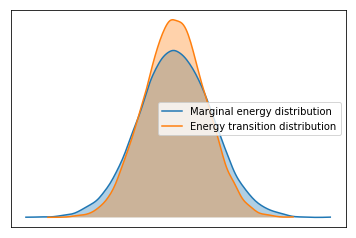

In [18]:
#Sample the model using jitter+adapt_diag as the initialization method for the NUTS sampler
#(parameters were chosen such that the sampling time is minimized while avoiding divergences)


with vote_major_model:
    major_trace = pm.sample(draws=2500,
                            tune=2500,
                            nuts_kwargs={'target_accept': 0.999},
                            init='jitter+adapt_diag',
                            njobs=6)

joblib.dump(major_trace, 'baseline_major.pkl')

#Check for sample convergence by calculating the Gelman-Rubin statistic

print(max(np.max(score) for score in pm.gelman_rubin(major_trace).values()))

#Compare the distribution of energy levels to the distribution of changes in energy levels between samples

pm.energyplot(major_trace)


Number of Divergent 0
Percentage of Divergent 0.00000


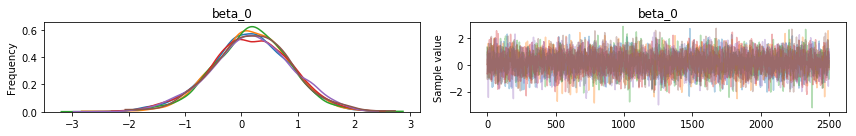

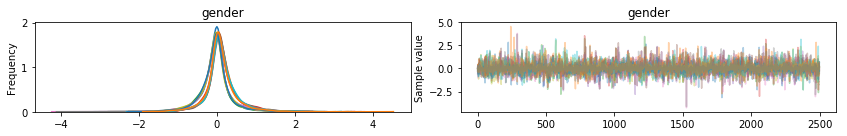

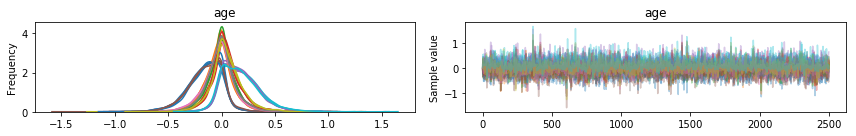

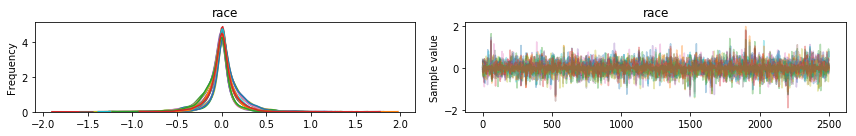

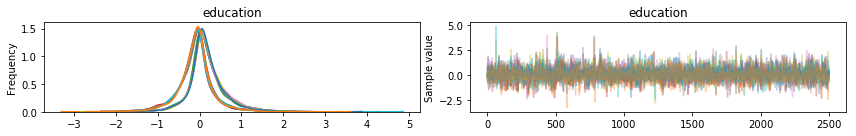

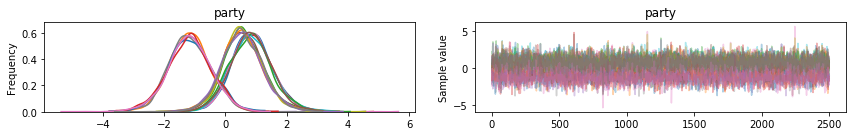

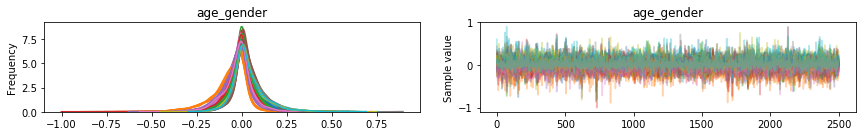

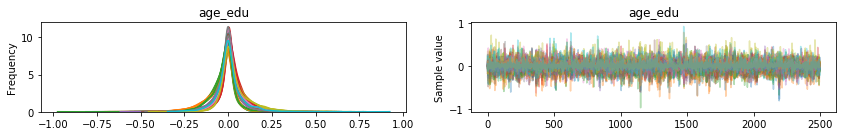

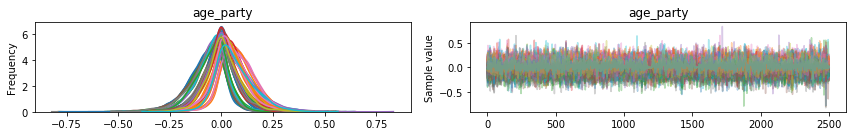

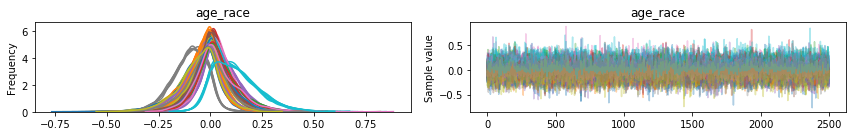

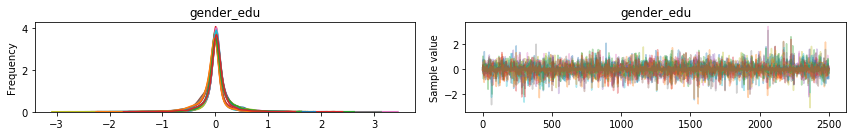

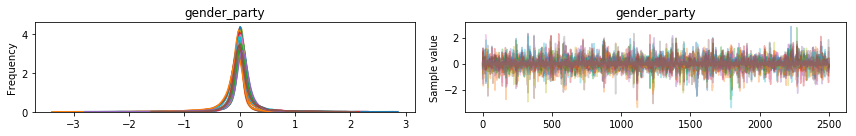

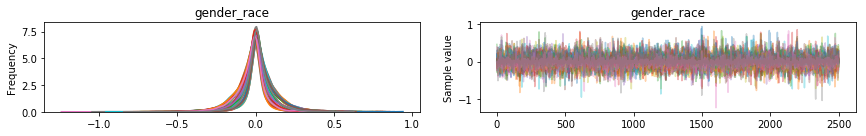

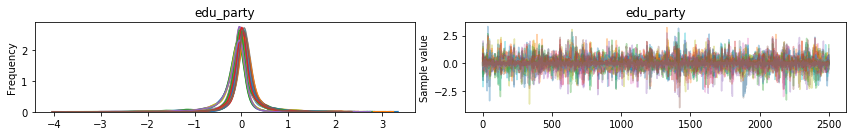

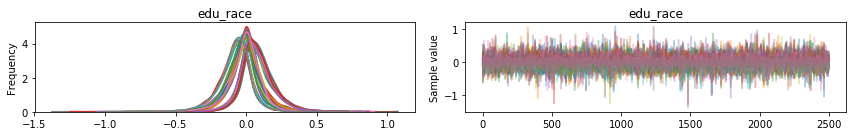

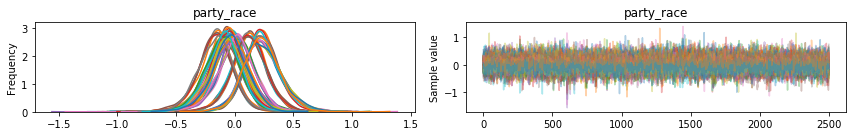

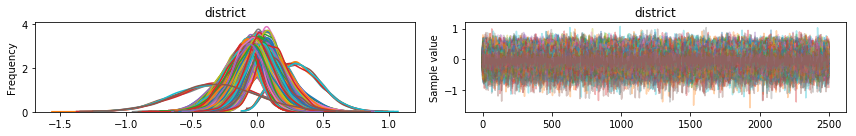

In [19]:
#Display the trace plot and density plot for each coefficient

model_vars = [beta_0,
              alpha_gender,
              alpha_age,
              alpha_race,
              alpha_edu,
              alpha_party,
              alpha_age_gender,
              alpha_age_edu,
              alpha_age_party,
              alpha_age_race,
              alpha_gender_edu,
              alpha_gender_party,
              alpha_gender_race,
              alpha_edu_party,
              alpha_edu_race,
              alpha_party_race,
              alpha_district]

for var in model_vars:
    pm.traceplot(major_trace, varnames=[var])
    
#Display the total number and percentage of divergent transitions

divergent = major_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(major_trace)
print('Percentage of Divergent %.5f' % divperc)


100%|██████████| 1000/1000 [00:02<00:00, 375.35it/s]


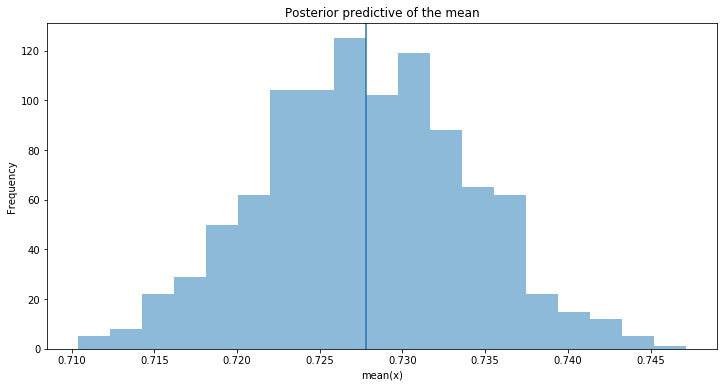

In [20]:
#Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean

major_ppc = pm.sample_ppc(major_trace, samples=1000, model=vote_major_model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in major_ppc['obs']], bins=19, alpha=0.5)
ax.axvline(major_train['Major Party Vote'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');


In [21]:
#Set the previously defined Theano variables to values for out of sample respondents

age.set_value(test['Age Encoded'].values)
gender.set_value(test['Gender Encoded'].values)
race.set_value(test['Race Encoded'].values)
party.set_value(test['Party Encoded'].values)
edu.set_value(test['Education Encoded'].values)

district.set_value(test['District Encoded'].values)

age_gender.set_value(test['Age_Gender'].values)
age_edu.set_value(test['Age_Edu'].values)
age_party.set_value(test['Age_Party'].values)
age_race.set_value(test['Age_Race'].values)
gender_edu.set_value(test['Gender_Edu'].values)
gender_party.set_value(test['Gender_Party'].values)
gender_race.set_value(test['Gender_Race'].values)
edu_party.set_value(test['Edu_Party'].values)
edu_race.set_value(test['Edu_Race'].values)
party_race.set_value(test['Party_Race'].values)

#Set the population count to each cell as one since the respondents aren't being aggregated together

n.set_value(np.ones(test.shape[0]))


In [22]:
#Draw 1,000 samples from the major party vote distribution based on the out of sample respondent data

with vote_major_model:
    major_pred_samples = pm.sample_ppc(major_trace, samples=1000)
    
#Average over the 1,000 sample values to generate the probability of each respondent voting for a major party

major_preds = np.mean(major_pred_samples['obs'], axis=0)

#Consider probabilities greater than 0.5 to mean that the respondent will vote for a major party

major_preds = np.where(major_preds > 0.5, 1, 0)


100%|██████████| 1000/1000 [00:01<00:00, 715.36it/s]


In [23]:
#Compute the predictive power of the model

major_acc = np.where(major_preds == test['Major Party Vote'], 1, 0).mean()
print('Major Party vote model out of sample prediction accuracy:', major_acc)


Major Party vote model out of sample prediction accuracy: 0.755116783048


In [24]:
#Set the previously defined Theano variables to the poststratification values

age.set_value(pops['Age Encoded'].values)
gender.set_value(pops['Gender Encoded'].values)
race.set_value(pops['Race Encoded'].values)
party.set_value(pops['Party Encoded'].values)
edu.set_value(pops['Education Encoded'].values)

district.set_value(pops['District Encoded'].values)

age_gender.set_value(pops['Age_Gender'].values)
age_edu.set_value(pops['Age_Edu'].values)
age_party.set_value(pops['Age_Party'].values)
age_race.set_value(pops['Age_Race'].values)
gender_edu.set_value(pops['Gender_Edu'].values)
gender_party.set_value(pops['Gender_Party'].values)
gender_race.set_value(pops['Gender_Race'].values)
edu_party.set_value(pops['Edu_Party'].values)
edu_race.set_value(pops['Edu_Race'].values)
party_race.set_value(pops['Party_Race'].values)

n.set_value(pops['n'].values)


100%|██████████| 1000/1000 [00:23<00:00, 42.39it/s]


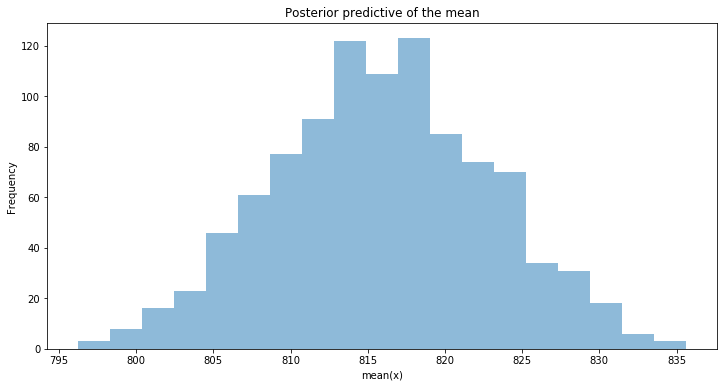

In [25]:
#Draw a new sample from the posterior predictive distribution

major_ps_ppc = pm.sample_ppc(major_trace, samples=1000, model=vote_major_model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in major_ps_ppc['obs']], bins=19, alpha=0.5)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');


In [26]:
#Merge the district-level data with the posterior distribution sample

PP_COLS = ['MAJOR_{}'.format(i) for i in range(major_ps_ppc['obs'].shape[0])]
pops = pd.merge(pops, pd.DataFrame(major_ps_ppc['obs'].T, columns=PP_COLS),
                  left_index=True, right_index=True)

#Calcuate the average probability of each demographic voting for a major party over all samples

major_cell_prob = pops.groupby(['US Congressional District',
                                'Gender',
                                'Race',
                                'Age',
                                'Education',
                                'What is your political party affiliation?']
                              ).apply(lambda df: df[PP_COLS].mean(axis=1)/df['n'])

#Drop the row poststratification space dataframe index

major_cell_prob.index = major_cell_prob.index.droplevel(6)

#Calculate a weighted average to obtain the probability of respodents in each state voting for a major party

major_area_prob = pops.groupby(['US Congressional District']
                              ).apply(lambda df: df[PP_COLS].sum(axis=0)/df['n'].sum()).mean(axis=1)


In [27]:
major_cell_prob.to_csv('major_cell_prob.csv')
major_cell_prob


US Congressional District  Gender  Race   Age      Education   What is your political party affiliation?
Alabama-1                  female  black  18 - 24  College     Democrat                                     0.788062
                                                               Independent                                  0.262270
                                                               Republican                                   0.650555
                                                   No college  Democrat                                     0.719529
                                                               Independent                                  0.177039
                                                               Republican                                   0.595412
                                          25 - 34  College     Democrat                                     0.835330
                                                               Independent  

In [28]:
major_area_prob


US Congressional District
Alabama-1          0.707015
Alabama-2          0.709529
Alabama-3          0.708132
Alabama-4          0.683717
Alabama-5          0.685039
Alabama-6          0.698709
Alabama-7          0.747058
Alaska-1           0.687816
Arizona-1          0.690849
Arizona-2          0.684894
Arizona-3          0.691537
Arizona-4          0.697041
Arizona-5          0.694598
Arizona-6          0.690120
Arizona-7          0.711694
Arizona-8          0.696252
Arizona-9          0.685400
Arkansas-1         0.663122
Arkansas-2         0.687381
Arkansas-3         0.687313
Arkansas-4         0.665080
California-1       0.691385
California-10      0.646303
California-11      0.703431
California-12      0.727662
California-13      0.760258
California-14      0.714349
California-15      0.672930
California-16      0.623746
California-17      0.736952
                     ...   
Virginia-2         0.691747
Virginia-3         0.724984
Virginia-4         0.736911
Virginia-5         0.6

# Democratic Party Vote Model

The model defined in this section will predict whether or not a respondent of a certain demographic will vote for the Democratic candidate given that he or she will vote for a major party candidate.


In [29]:
#Group the respondents who plan to vote for a major party candidate by the demographic variables used in the modoel

dem_train = train.loc[train['Major Party Vote'] == 1].groupby(['Gender Encoded',
                                                               'Race Encoded',
                                                               'Age Encoded',
                                                               'Education Encoded',
                                                               'Party Encoded',
                                                               'Age_Gender',
                                                               'Age_Edu',
                                                               'Age_Party',
                                                               'Age_Race',
                                                               'Gender_Edu',
                                                               'Gender_Party',
                                                               'Gender_Race',
                                                               'Edu_Party',
                                                               'Edu_Race',
                                                               'Party_Race',
                                                               'District Encoded',
                                                               'Division Encoded'
                                                              ])['Who will you vote|Will vote Democratic']

#Aggregate the number of respondents in each cell who plan on voting for a Democratic candidate

dem_train = dem_train.agg([('Who will you vote|Will vote Democratic', 'sum'), ('n', 'size')]).reset_index()


In [30]:
#Create Theano constant variables for the demographic and marginal demographic variables

age = shared(dem_train['Age Encoded'].values)
gender = shared(dem_train['Gender Encoded'].values)
race = shared(dem_train['Race Encoded'].values)
party = shared(dem_train['Party Encoded'].values)
edu = shared(dem_train['Education Encoded'].values)
district = shared(dem_train['District Encoded'].values)

age_gender = shared(dem_train['Age_Gender'].values)
age_edu = shared(dem_train['Age_Edu'].values)
age_party = shared(dem_train['Age_Party'].values)
age_race = shared(dem_train['Age_Race'].values)
gender_edu = shared(dem_train['Gender_Edu'].values)
gender_party = shared(dem_train['Gender_Party'].values)
gender_race = shared(dem_train['Gender_Race'].values)
edu_party = shared(dem_train['Edu_Party'].values)
edu_race = shared(dem_train['Edu_Race'].values)
party_race = shared(dem_train['Party_Race'].values)

#Create a Theano constant variable for the number of observations in each population cell

n = shared(dem_train['n'].values, allow_downcast=True)


In [31]:
with pm.Model() as vote_dem_model:
    alpha_division = hierarchical_normal(name='region',
                                         shape=pops['Division Encoded'].unique().size)
    beta_trump = pm.Normal('trump', 0.0 , 1.0)
    beta_cook = pm.Normal('PVI', 0.0, 1.0)
    mu_district = alpha_division[cook['Division Encoded'].values] + beta_trump*cook['Trump Vote'] + beta_cook*cook['PVI']
    alpha_district = hierarchical_normal(name='district',
                                         shape=pops['District Encoded'].unique().size,
                                         mu=mu_district)

    beta_0 = pm.Normal('beta_0', 0.0, 1.0,
                       testval=logit(train['Who will you vote|Will vote Democratic'].values.mean()))
     
    alpha_age = hierarchical_normal(name='age',
                                    shape=train['Age Encoded'].unique().size)
    alpha_gender = hierarchical_normal(name='gender',
                                       shape=train['Gender Encoded'].unique().size)
    alpha_race = hierarchical_normal(name='race',
                                     shape=train['Race Encoded'].unique().size)
    alpha_edu = hierarchical_normal(name='education',
                                    shape=train['Education Encoded'].unique().size)
    alpha_party = hierarchical_normal(name='party',
                                      shape=train['Party Encoded'].unique().size)
    
    alpha_age_gender = hierarchical_normal(name='age_gender',
                                           shape=train['Age_Gender'].unique().size)
    alpha_age_edu = hierarchical_normal(name='age_edu',
                                        shape=train['Age_Edu'].unique().size)
    alpha_age_party = hierarchical_normal(name='age_party',
                                          shape=train['Age_Party'].unique().size)
    alpha_age_race = hierarchical_normal(name='age_race',
                                         shape=train['Age_Race'].unique().size)
    alpha_gender_edu = hierarchical_normal(name='gender_edu',
                                           shape=train['Gender_Edu'].unique().size)
    alpha_gender_party = hierarchical_normal(name='gender_party',
                                             shape=train['Gender_Party'].unique().size)
    alpha_gender_race = hierarchical_normal(name='gender_race',
                                            shape=train['Gender_Race'].unique().size)
    alpha_edu_party = hierarchical_normal(name='edu_party',
                                          shape=train['Edu_Party'].unique().size)
    alpha_edu_race = hierarchical_normal(name='edu_race',
                                         shape=train['Edu_Race'].unique().size)
    alpha_party_race = hierarchical_normal(name='party_race',
                                           shape=train['Party_Race'].unique().size)
    
    eta = (beta_0 +
           alpha_age[age] +
           alpha_gender[gender] +
           alpha_race[race] +
           alpha_edu[edu] +
           alpha_party[party] +
           alpha_age_gender[age_gender] +
           alpha_age_edu[age_edu] +
           alpha_age_party[age_party] +
           alpha_age_race[age_race] +
           alpha_gender_edu[gender_edu] +
           alpha_gender_party[gender_party] +
           alpha_gender_race[gender_race] +
           alpha_edu_party[edu_party] +
           alpha_edu_race[edu_race] +
           alpha_party_race[party_race] +
           alpha_district[district])


    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n, p,
                      observed=dem_train['Who will you vote|Will vote Democratic'].values)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_party_race_log__, delta_party_race, sigma_edu_race_log__, delta_edu_race, sigma_edu_party_log__, delta_edu_party, sigma_gender_race_log__, delta_gender_race, sigma_gender_party_log__, delta_gender_party, sigma_gender_edu_log__, delta_gender_edu, sigma_age_race_log__, delta_age_race, sigma_age_party_log__, delta_age_party, sigma_age_edu_log__, delta_age_edu, sigma_age_gender_log__, delta_age_gender, sigma_party_log__, delta_party, sigma_education_log__, delta_education, sigma_race_log__, delta_race, sigma_gender_log__, delta_gender, sigma_age_log__, delta_age, beta_0, sigma_district_log__, delta_district, PVI, trump, sigma_region_log__, delta_region]
100%|██████████| 5000/5000 [3:32:36<00:00,  2.21s/it]  
The number of effective samples is smaller than 25% for some parameters.


1.00093859133


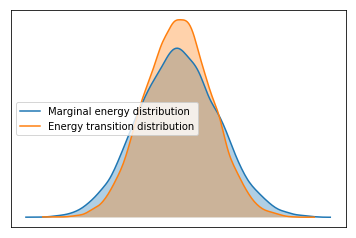

In [32]:
#Sample the model using jitter+adapt_diag as the initialization method for the NUTS sampler
#(parameters were chosen such that the sampling time is minimized while avoiding divergences)


with vote_dem_model:
    dem_trace = pm.sample(draws=2500,
                          tune=2500,
                          nuts_kwargs={'target_accept': 0.999},
                          init='jitter+adapt_diag',
                          njobs=6)

joblib.dump(dem_trace, 'baseline_dem.pkl')

#Check for sample convergence by calculating the Gelman-Rubin statistic

print(max(np.max(score) for score in pm.gelman_rubin(dem_trace).values()))

#Compare the distribution of energy levels to the distribution of changes in energy levels between samples

pm.energyplot(dem_trace)


Number of Divergent 0
Percentage of Divergent 0.00000


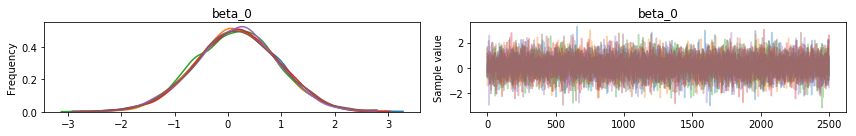

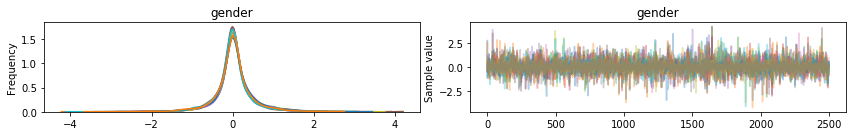

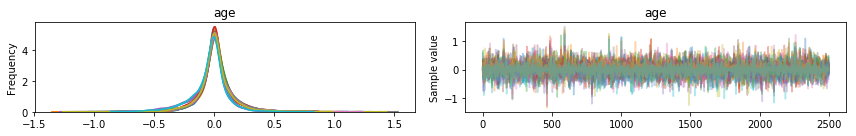

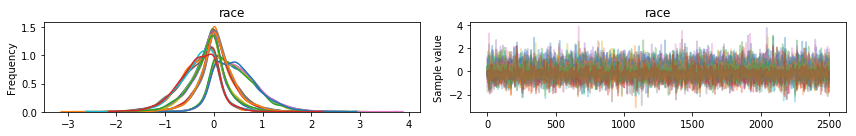

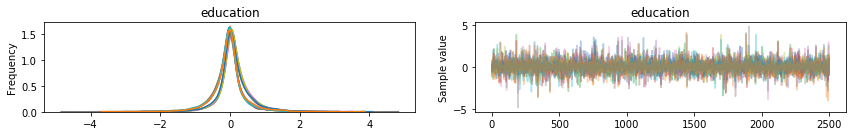

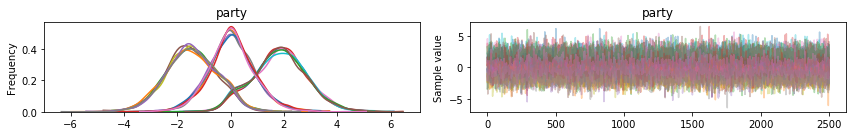

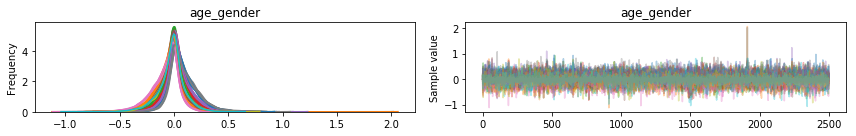

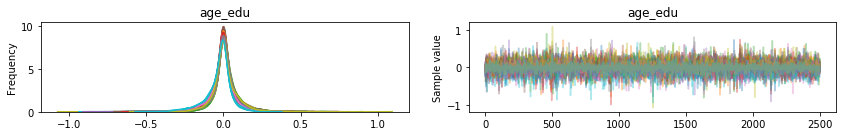

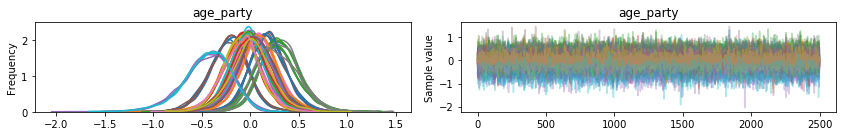

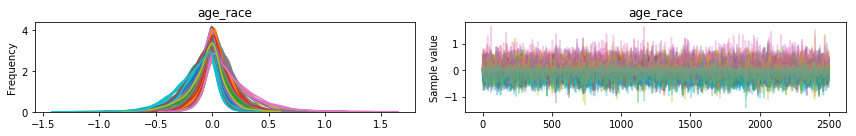

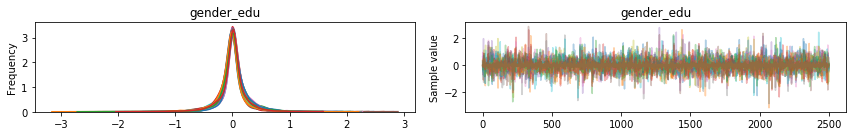

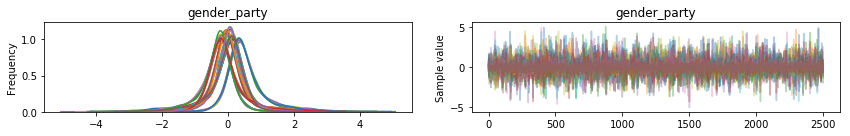

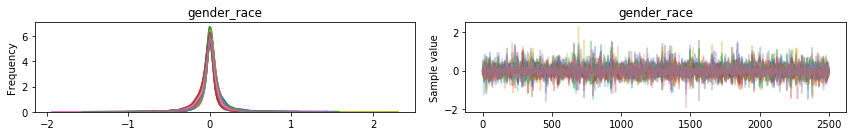

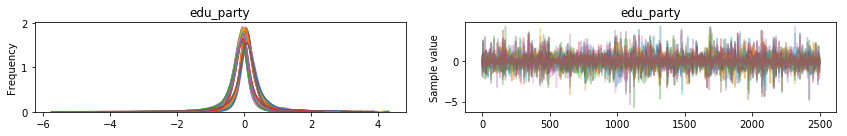

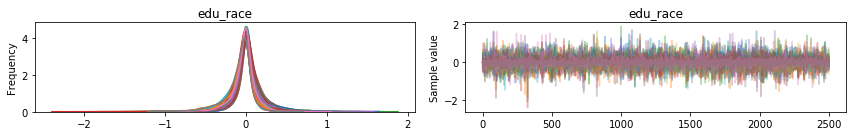

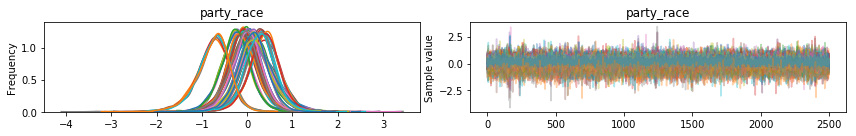

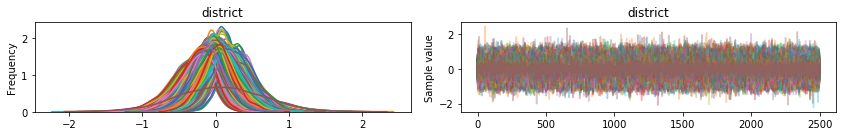

In [33]:
#Display the trace plot and density plot for each coefficient

model_vars = [beta_0,
              alpha_gender,
              alpha_age,
              alpha_race,
              alpha_edu,
              alpha_party,
              alpha_age_gender,
              alpha_age_edu,
              alpha_age_party,
              alpha_age_race,
              alpha_gender_edu,
              alpha_gender_party,
              alpha_gender_race,
              alpha_edu_party,
              alpha_edu_race,
              alpha_party_race,
              alpha_district]

for var in model_vars:
    pm.traceplot(dem_trace, varnames=[var])
    
#Display the total number and percentage of divergent transitions

divergent = dem_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(dem_trace)
print('Percentage of Divergent %.5f' % divperc)


100%|██████████| 1000/1000 [00:02<00:00, 474.84it/s]


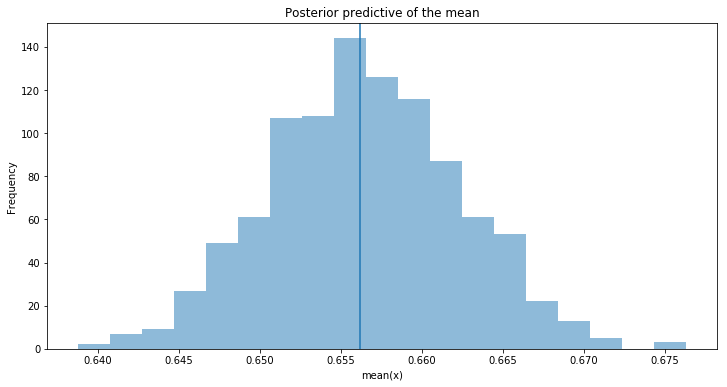

In [34]:
#Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean

dem_ppc = pm.sample_ppc(dem_trace, samples=1000, model=vote_dem_model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in dem_ppc['obs']], bins=19, alpha=0.5)
ax.axvline(dem_train['Who will you vote|Will vote Democratic'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');


In [35]:
#Set the previously defined Theano variables to the values of out of sample respondents voting for a major party

age.set_value(test.loc[test['Major Party Vote'] == 1, 'Age Encoded'].values)
gender.set_value(test.loc[test['Major Party Vote'] == 1, 'Gender Encoded'].values)
race.set_value(test.loc[test['Major Party Vote'] == 1, 'Race Encoded'].values)
party.set_value(test.loc[test['Major Party Vote'] == 1, 'Party Encoded'].values)
edu.set_value(test.loc[test['Major Party Vote'] == 1, 'Education Encoded'].values)

district.set_value(test.loc[test['Major Party Vote'] == 1, 'District Encoded'].values)

age_gender.set_value(test.loc[test['Major Party Vote'] == 1, 'Age_Gender'].values)
age_edu.set_value(test.loc[test['Major Party Vote'] == 1, 'Age_Edu'].values)
age_party.set_value(test.loc[test['Major Party Vote'] == 1, 'Age_Party'].values)
age_race.set_value(test.loc[test['Major Party Vote'] == 1, 'Age_Race'].values)
gender_edu.set_value(test.loc[test['Major Party Vote'] == 1, 'Gender_Edu'].values)
gender_party.set_value(test.loc[test['Major Party Vote'] == 1, 'Gender_Party'].values)
gender_race.set_value(test.loc[test['Major Party Vote'] == 1, 'Gender_Race'].values)
edu_party.set_value(test.loc[test['Major Party Vote'] == 1, 'Edu_Party'].values)
edu_race.set_value(test.loc[test['Major Party Vote'] == 1, 'Edu_Race'].values)
party_race.set_value(test.loc[test['Major Party Vote'] == 1, 'Party_Race'].values)

#Set the population count to each cell as one since the respondents aren't being aggregated together

n.set_value(np.ones(test.loc[test['Major Party Vote'] == 1].shape[0]))


In [36]:
#Draw 1,000 samples from the Democratic Party vote distribution based on the out of sample respondent data

with vote_dem_model:
    dem_pred_samples = pm.sample_ppc(dem_trace, samples=1000)
    
#Average over the 1,000 sample values to generate the probability of each respondent voting for the Democratic Party

dem_preds = np.mean(dem_pred_samples['obs'], axis=0)

#Consider probabilities greater than 0.5 to mean that the respondent will vote for the Democratic Party

dem_preds = np.where(dem_preds > 0.5, 1, 0)


100%|██████████| 1000/1000 [00:01<00:00, 837.77it/s]


In [37]:
#Compute the predictive power of the model

dem_acc = np.where(dem_preds == test.loc[test['Major Party Vote'] == 1,
                                         'Who will you vote|Will vote Democratic'], 1, 0).mean()

print('Democratic Party vote model out of sample prediction accuracy:', dem_acc)


Democratic Party vote model out of sample prediction accuracy: 0.865039152464


In [38]:
#Set the previously defined Theano variables to the poststratification values

age.set_value(pops['Age Encoded'].values)
gender.set_value(pops['Gender Encoded'].values)
race.set_value(pops['Race Encoded'].values)
party.set_value(pops['Party Encoded'].values)
edu.set_value(pops['Education Encoded'].values)

district.set_value(pops['District Encoded'].values)

age_gender.set_value(pops['Age_Gender'].values)
age_edu.set_value(pops['Age_Edu'].values)
age_party.set_value(pops['Age_Party'].values)
age_race.set_value(pops['Age_Race'].values)
gender_edu.set_value(pops['Gender_Edu'].values)
gender_party.set_value(pops['Gender_Party'].values)
gender_race.set_value(pops['Gender_Race'].values)
edu_party.set_value(pops['Edu_Party'].values)
edu_race.set_value(pops['Edu_Race'].values)
party_race.set_value(pops['Party_Race'].values)

n.set_value(pops['n'].values)


100%|██████████| 1000/1000 [00:24<00:00, 42.14it/s]


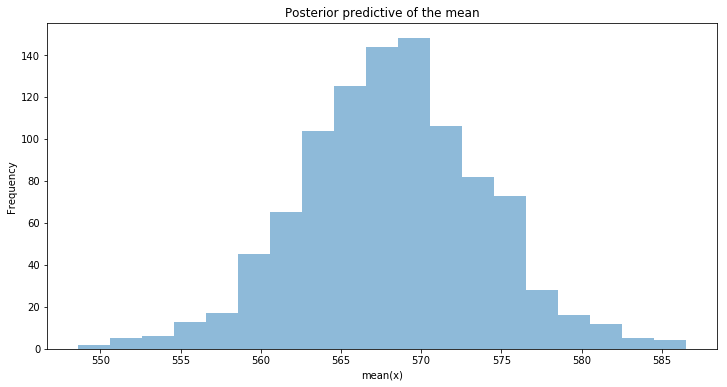

In [39]:
#Draw a new poststratification sample from the posterior predictive distribution

dem_ps_ppc = pm.sample_ppc(dem_trace, samples=1000, model=vote_dem_model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in dem_ps_ppc['obs']], bins=19, alpha=0.5)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');


In [40]:
#Merge the state-level data with the posterior distribution sample

PP_COLS = ['DEM_{}'.format(i) for i in range(dem_ps_ppc['obs'].shape[0])]
pops = pd.merge(pops, pd.DataFrame(dem_ps_ppc['obs'].T, columns=PP_COLS),
                  left_index=True, right_index=True)

#Calcuate the average probability of each demographic voting for a Democratic candidate over all samples

dem_cell_prob = pops.groupby(['US Congressional District',
                              'Gender',
                              'Race',
                              'Age',
                              'Education',
                              'What is your political party affiliation?'
                             ]).apply(lambda df: df[PP_COLS].mean(axis=1)/df['n'])

#Drop the poststratification space dataframe index

dem_cell_prob.index = dem_cell_prob.index.droplevel(6)

#Calculate a weighted average to obtain the probability of respodents in each state voting for a Democratic candidate

dem_district_prob = pops.groupby(['US Congressional District']
                                ).apply(lambda df: df[PP_COLS].sum(axis=0)/df['n'].sum()).mean(axis=1)


In [41]:
dem_cell_prob.to_csv('dem_cell_prob.csv')
dem_cell_prob


US Congressional District  Gender  Race   Age      Education   What is your political party affiliation?
Alabama-1                  female  black  18 - 24  College     Democrat                                     0.962649
                                                               Independent                                  0.719905
                                                               Republican                                   0.319900
                                                   No college  Democrat                                     0.942864
                                                               Independent                                  0.620407
                                                               Republican                                   0.296781
                                          25 - 34  College     Democrat                                     0.967269
                                                               Independent  

In [42]:
dem_district_prob


US Congressional District
Alabama-1          0.349965
Alabama-2          0.391189
Alabama-3          0.364003
Alabama-4          0.198722
Alabama-5          0.337635
Alabama-6          0.275171
Alabama-7          0.742863
Alaska-1           0.377359
Arizona-1          0.464940
Arizona-2          0.502890
Arizona-3          0.655864
Arizona-4          0.262942
Arizona-5          0.303578
Arizona-6          0.328306
Arizona-7          0.772993
Arizona-8          0.343273
Arizona-9          0.511000
Arkansas-1         0.463496
Arkansas-2         0.492201
Arkansas-3         0.275216
Arkansas-4         0.485436
California-1       0.340172
California-10      0.457456
California-11      0.648985
California-12      0.797741
California-13      0.873163
California-14      0.714178
California-15      0.670478
California-16      0.527296
California-17      0.693880
                     ...   
Virginia-2         0.444241
Virginia-3         0.676597
Virginia-4         0.594681
Virginia-5         0.4

# Two Party Vote Share Conditioned on Major Party Vote Probability

Using the probabilities generated by the previous two models, the probability of a respondent from state $s$ voting for a democratic candidate in the 2018 House of Representatives elections given that he or she will be voting for a major party candidate can be calculated using the following formula:

$p_{s}=\frac{\sum_{j \in s}{N_{j}\pi^{major}_{j}\pi^{dem}_{j}}}{\sum_{j \in s}{N_{j}\pi^{major}_{j}}}$

Each $\pi$ in this formula represents a vector where each value represents a probability associated with a specific demographic cell. $N_{j}$ repreesnts a vector containing the population counts for each demographic cell in state $s$.

In [43]:
 N = pops.sort_values(['US Congressional District',
                      'Gender',
                      'Race',
                      'Age',
                      'Education',
                      'What is your political party affiliation?'
                     ]).set_index(['US Congressional District',
                                   'Gender',
                                   'Race',
                                   'Age',
                                   'Education',
                                   'What is your political party affiliation?'])['n']
numerator = (N*(major_cell_prob*dem_cell_prob).values).groupby(['US Congressional District']).sum()
denominator = (N*major_cell_prob.values).groupby(['US Congressional District']).sum()
p = numerator/denominator


In [44]:
#Calculate the predicted Republican vote share

vote_model = pd.DataFrame(data=[p, 1 - p]).transpose().reset_index()
vote_model.columns = ['District', 'Democratic Party Vote Share', 'Republican Party Vote Share']

#Check the predicted Democratic vote share by comparing the RMSE with Clinton's 2016 Election vote share

print('Root Mean Squared Error (Predicted Democratic Party Vote Share vs. Clinton 2016 Election Vote Share:', 
      np.sqrt(mean_squared_error(vote_model.merge(cook)['Clinton Vote'],
                                 vote_model.merge(cook)['Democratic Party Vote Share'])))


Root Mean Squared Error (Predicted Democratic Party Vote Share vs. Clinton 2016 Election Vote Share: 0.072386645093


In [45]:
vote_model.to_csv('baseline_district_vote_share.csv')
vote_model


,District,Democratic Party Vote Share,Republican Party Vote Share
0,Alabama-1,0.345596,0.654404
1,Alabama-2,0.391425,0.608575
2,Alabama-3,0.364732,0.635268
3,Alabama-4,0.178063,0.821937
4,Alabama-5,0.327371,0.672629
5,Alabama-6,0.256562,0.743438
6,Alabama-7,0.765040,0.234960
7,Alaska-1,0.369000,0.631000
8,Arizona-1,0.462397,0.537603
9,Arizona-2,0.505074,0.494926
